### Import Necessary Libraries

In [ ]:
from collections import defaultdict
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from codecs import open
from __future__ import division


### Data Preprocessing

In [ ]:
def preprocess_text(text):
    text = text.lower()
    stop_words = set(ENGLISH_STOP_WORDS)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])

    return text

def preprocess_documents(docs):
    return [preprocess_text(' '.join(doc)) for doc in docs]

def read_documents(doc_file):
    docs = []
    labels = []
    with open(doc_file, encoding='utf-8') as f:
        for line in f:
            words = line.strip().split()
            if len(words) > 3:
                docs.append(words[3:])
                labels.append(words[1])
    return docs, labels



### Visualization of Our Data

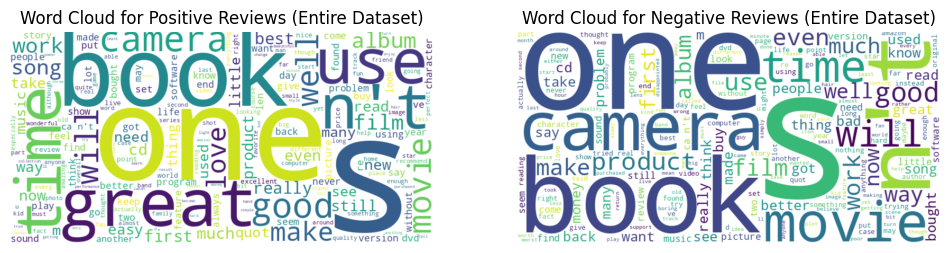

In [ ]:
all_docs, all_labels = read_documents('/content/all_sentiment_shuffled.rtf')
split_point = int(0.80 * len(all_docs))
train_docs = all_docs[:split_point]
train_labels = all_labels[:split_point]
eval_docs = all_docs[split_point:]
eval_labels = all_labels[split_point:]

pos_reviews_all = ' '.join([' '.join(doc) for doc, label in zip(all_docs, all_labels) if label == 'pos'])
neg_reviews_all = ' '.join([' '.join(doc) for doc, label in zip(all_docs, all_labels) if label == 'neg'])

wordcloud_pos_all = WordCloud(width=800, height=400, background_color='white').generate(pos_reviews_all)
wordcloud_neg_all = WordCloud(width=800, height=400, background_color='white').generate(neg_reviews_all)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos_all, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews (Entire Dataset)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg_all, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews (Entire Dataset)')
plt.axis('off')

plt.show()


### Training and Evaluating the Model

In [ ]:
def train_nb(documents, labels, smoothing=1.0):
    class_word_counts = defaultdict(lambda: defaultdict(int))
    class_counts = defaultdict(int)
    total_words = 0

    for doc, label in zip(documents, labels):
        for word in doc:
            class_word_counts[label][word] += 1
            class_counts[label] += 1
            total_words += 1

    class_probs = {}
    for label, word_counts in class_word_counts.items():
        class_probs[label] = {}
        for word, count in word_counts.items():
            class_probs[label][word] = np.log((count + smoothing) / (class_counts[label] + smoothing * total_words))

    return class_probs

def score_doc_label(document, label_probs):
    log_prob = 0.0
    for word in document:
        if word in label_probs:
            log_prob += label_probs[word]
    return log_prob

def classify_nb(document, label_probs):
    pos_score = score_doc_label(document, label_probs['pos'])
    neg_score = score_doc_label(document, label_probs['neg'])

    return 'pos' if pos_score > neg_score else 'neg'


def classify_documents(docs, label_probs):
    predictions = [classify_nb(doc, label_probs) for doc in docs]
    return predictions


def accuracy(true_labels, guessed_labels):
    correct = sum(1 for true, guessed in zip(true_labels, guessed_labels) if true == guessed)
    total = len(true_labels)
    return correct / total


def cross_validation(all_docs, all_labels, N=10, smoothing=1.0):
    accuracies = []

    for fold_nbr in range(N):
        split_point_1 = int(float(fold_nbr) / N * len(all_docs))
        split_point_2 = int(float(fold_nbr + 1) / N * len(all_docs))

        train_docs_fold = all_docs[:split_point_1] + all_docs[split_point_2:]
        train_labels_fold = all_labels[:split_point_1] + all_labels[split_point_2:]
        eval_docs_fold = all_docs[split_point_1:split_point_2]
        eval_labels_fold = all_labels[split_point_1:split_point_2]

        label_probs = train_nb(train_docs_fold, train_labels_fold, smoothing)
        predictions = classify_documents(eval_docs_fold, label_probs)
        accuracies.append(accuracy(eval_labels_fold, predictions))

    mean_accuracy = np.mean(accuracies)\

    interval = 1.96 * np.std(accuracies) / np.sqrt(N)

    return mean_accuracy, mean_accuracy - interval, mean_accuracy + interval


label_probs = train_nb(train_docs, train_labels, smoothing=1.0)


predictions = classify_documents(eval_docs, label_probs)
acc = accuracy(eval_labels, predictions)
print(f"Accuracy on the test set: {acc}")


mean_acc, lower_bound, upper_bound = cross_validation(all_docs, all_labels)
print(f"Mean Accuracy: {mean_acc}, 95% Confidence Interval: ({lower_bound}, {upper_bound})")


Accuracy on the test set: 0.565673520772136
Mean Accuracy: 0.5531322023678709, 95% Confidence Interval: (0.5437029896863135, 0.5625614150494282)


### Evaluating the Model Performance

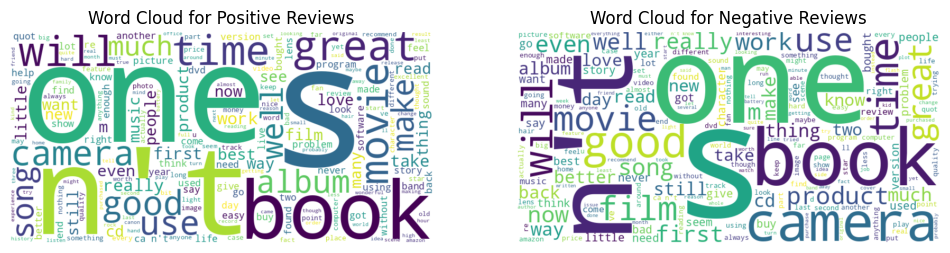

In [ ]:
# Create a word cloud for predictions of our model on the test set

pos_reviews = ' '.join([' '.join(doc) for doc, label in zip(eval_docs, predictions) if label == 'pos'])
neg_reviews = ' '.join([' '.join(doc) for doc, label in zip(eval_docs, predictions) if label == 'neg'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(neg_reviews)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')

plt.show()


Accuracy on the test set: 0.565673520772136


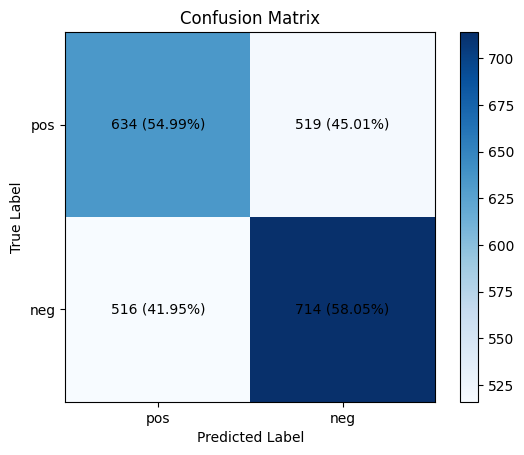

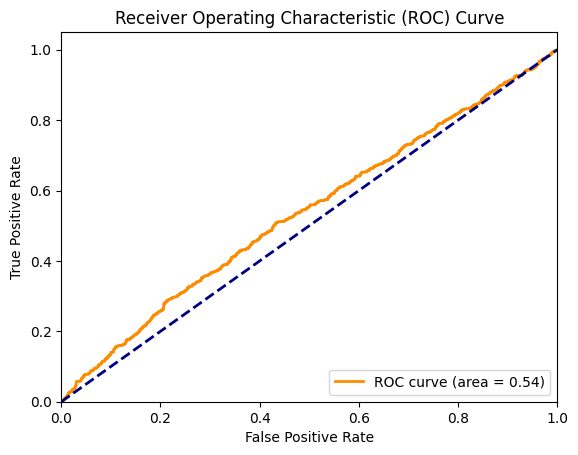

In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    for i in range(len(classes)):
        for j in range(len(classes)):
            percentage = cm[i, j] / cm[i, :].sum() * 100
            ax.text(j, i, f'{cm[i, j]} ({percentage:.2f}%)', ha='center', va='center', color='black')

    ax.set(xticks=np.arange(len(classes)),
           yticks=np.arange(len(classes)),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True Label',
           xlabel='Predicted Label')

    plt.show()


def plot_roc_curve(true_labels, predicted_probs):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs, pos_label='pos')
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


label_probs = train_nb(train_docs, train_labels, smoothing=1.0)


predictions = classify_documents(eval_docs, label_probs)


acc = accuracy(eval_labels, predictions)
print(f"Accuracy on the test set: {acc}")


plot_confusion_matrix(eval_labels, predictions, classes=['pos', 'neg'])

pos_probs = [score_doc_label(doc, label_probs['pos']) for doc in eval_docs]
plot_roc_curve(eval_labels, pos_probs)


In [ ]:
print("\nClassification Report:")
print(classification_report(eval_labels, predictions, target_names=['pos', 'neg']))


Classification Report:
              precision    recall  f1-score   support

         pos       0.58      0.58      0.58      1230
         neg       0.55      0.55      0.55      1153

    accuracy                           0.57      2383
   macro avg       0.57      0.57      0.57      2383
weighted avg       0.57      0.57      0.57      2383

